In [430]:
from os import listdir
from os.path import isfile, join
from sklearn.metrics import accuracy_score, roc_curve, confusion_matrix
import math

%matplotlib inline
import matplotlib.pyplot as plt


In [431]:
root_path = './data/messages'


In [432]:
def get_n_grams_from_message(path, ngrams):
    result = set()
    with open(path) as f:
        subject = f.readline().split()[1:]
        f.readline()
        message = f.readline().split()
        for i in range(len(subject) + 1 - ngrams):
            result.add(' '.join(subject[i:i+ngrams]))
        for i in range(len(message) + 1 - ngrams):
            result.add(' '.join(message[i:i+ngrams]))
    return result


In [433]:
def get_files_from_dir(path):
    return [f for f in listdir(path) if isfile(join(path, f))]


In [434]:
flatten = lambda t: [item for sublist in t for item in sublist]


In [435]:
def bayes(X, Y, alpha, lambda_legit, lambda_spam):
    wordToClass = dict()

    for i in range(len(X)):
        for word in X[i]:
            if wordToClass.get(word) is None:
                wordToClass[word] = [0, 0]
            wordToClass[word][Y[i]] += 1


    total_messages_count = len(Y)
    spam_message_count = sum(Y)

    k = 2
    class_count = [total_messages_count - spam_message_count, spam_message_count]
    lam = [lambda_spam, lambda_legit]

    precalc = [0.0] * k

    for i in range(k):
        if class_count[i] != 0:
            precalc[i] = math.log(1.0 * class_count[i] * lam[i] / total_messages_count)

    for w in set(wordToClass.keys()):
        st = wordToClass[w]
        for i in range(k):
            if class_count[i] != 0:
                precalc[i] += math.log(1 - (st[i] + alpha) / (class_count[i] + 2 * alpha))

    def predict(words):
        cr = precalc.copy()

        for w in words:
            for i in range(k):
                if class_count[i] != 0:
                    if wordToClass.get(w) is not None:
                        st = wordToClass[w]
                        pr = (st[i] + alpha) / (class_count[i] + 2 * alpha)
                        cr[i] += math.log(pr) - math.log(1 - pr)

        cr = [math.e ** (x - max(cr)) for x in cr]
        probability_of_legit = cr[1] / (cr[0] + cr[1])

        return probability_of_legit >= 0.5, probability_of_legit

    return predict


In [436]:
def read_folder(i, ngrams):
    X = []
    Y = []

    path = root_path + f'/part{i}'
    all_files = get_files_from_dir(path)

    for file in all_files:
        full_file_name = join(path, file)
        messages = get_n_grams_from_message(full_file_name, ngrams)
        X.append(messages)

        is_legit = 0 if 'spmsg' in file else 1
        Y.append(is_legit)

    return X, Y


In [437]:
def plot_roc_curve(Y_real, Y_probabilities):
    fpr, tpr, thresholds = roc_curve(Y_real, Y_probabilities)

    plt.plot(fpr, tpr, linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.xlabel('False Positive Rate, FPR (1 - specificity)')
    plt.ylabel('True Positive Rate, TPR (Recall)')
    plt.title('ROC curve')
    # plt.savefig("ROC.png")
    plt.show()


In [438]:
def processing_inner(ngrams, alpha, lambda_legit, lambda_spam):
    X_fold = []
    Y_fold = []

    for i in range(1, 11):
        X, Y = read_folder(i, ngrams)
        X_fold.append(X)
        Y_fold.append(Y)

    Y_predicted = []
    Y_probabilities = []
    Y_test_all = flatten(Y_fold)

    for test_index in range(10):
        train_indexes = set(range(10))
        train_indexes.remove(test_index)

        X = flatten([X_fold[i] for i in train_indexes])
        Y = flatten([Y_fold[i] for i in train_indexes])

        X_test, Y_test = X_fold[test_index], Y_fold[test_index]

        model = bayes(X, Y, alpha, lambda_legit, lambda_spam)

        for test in X_test:
            predicted, probabilities = model(test)
            Y_predicted.append(predicted)
            Y_probabilities.append(probabilities)

    return Y_test_all, Y_predicted, Y_probabilities


In [439]:
def processing_accuracy_roc(ngrams, alpha, lambda_legit, lambda_spam):
    Y_test_all, Y_predicted, Y_probabilities = processing_inner(ngrams, alpha, lambda_legit, lambda_spam)

    accuracy = accuracy_score(Y_test_all, Y_predicted)

    print('accuracy:', accuracy)

    plot_roc_curve(Y_test_all, Y_probabilities)


In [440]:
def processing_confusion_matrix(ngrams, alpha, lambda_legit, lambda_spam):
    Y_test_all, Y_predicted, Y_probabilities = processing_inner(ngrams, alpha, lambda_legit, lambda_spam)

    accuracy = accuracy_score(Y_test_all, Y_predicted)

    cmatrix = confusion_matrix(Y_test_all, Y_predicted)

    print(cmatrix)

    print('accuracy:', accuracy)


accuracy: 0.9788990825688073


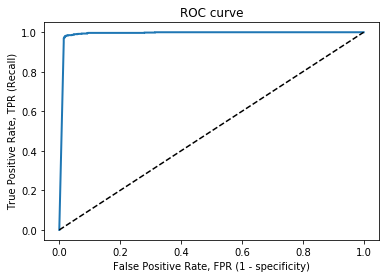

In [441]:
processing_accuracy_roc(
    ngrams=1,
    alpha=0.00001,
    lambda_legit=0.00001,
    lambda_spam=100,
)


In [442]:
processing_confusion_matrix(
    ngrams=3,
    alpha=0.1,
    lambda_legit=1,
    lambda_spam=1
)


[[311 169]
 [  0 610]]
accuracy: 0.844954128440367


In [444]:
accuracy_array = []

for i in range(-6, 1):
    Y_test_all, Y_predicted, Y_probabilities = processing_inner(
        ngrams=3,
        alpha=0.1,
        lambda_legit=10 ** i,
        lambda_spam=1
    )

    accuracy_array.append(accuracy_score(Y_test_all, Y_predicted))


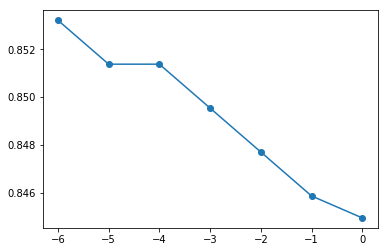

In [445]:
plt.plot(list(range(-6, 1)), accuracy_array, marker='o')
plt.show()

In [446]:
# processing_no_spam(
#     ngrams=3,
#     alpha=0.001,
#     lambda_legit=1000000,
#     lambda_spam=0.000001
# )


In [447]:
# processing_no_spam(
#     ngrams=1,
#     alpha=0.1,
#     lambda_legit=1000000000000,
#     lambda_spam=0.000000000001
# )
